In [1]:
import sys
from pathlib import Path
BASE_PATH = Path("/home/omarelb/projects/thesis/code/")
sys.path.append(BASE_PATH.as_posix())
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shutil
import regex as re
import yaml
from pd_replicator import replicator

from IPython.display import display, Markdown

plt.rcParams["figure.figsize"] = [20,10]

%load_ext autoreload
%autoreload 2

from LearningToRelearn.learner import METRICS_FILE, RESULTS_DIR, flatten_dict

from result_analysis import analyze_results, learning_curve_area, learning_slope, get_forgetting

EXPERIMENT_DIR = BASE_PATH / "experiments"

# experiment = EXPERIMENT_DIR / "learner.samples_per_task=[5000,2000],learner=sequential,task_order=[amazon,yahoo],testing.eval_dataset=amazon,testing.few_shot_batch_size=1,testing.n_samples=256_2021-05-04_10-50-08_measure-relearning-baseline-1/seed=42"

# results_file = experiment / RESULTS_DIR / "results.json"
# metrics_file = experiment / RESULTS_DIR / "metrics.json"

## Preparation

In [102]:
# experiments = list(EXPERIMENT_DIR.glob("measure-relearning-multiple-eval-order*-1-10000_*/seed*/"))
# experiments = list(EXPERIMENT_DIR.glob("measure-relearning-multiple-eval-*order-1*-10000*"))
order = 4
samples = 115000
model = "mamlNoReplay"
models = ("baseline", "mamlNoReplay", "omlNoReplay", "replay")
orders = (1,2,3,4)
# for order in (1,2,3,4):
#     for samples in (10000, 50000, 100000):
different_models = [
    (f"measure-relearning-multiple-eval-baseline-all-order-{order}-{samples}$", "BERT"),
    (f"measure-relearning-multiple-eval-mamlNoReplay-all-order-{order}-{samples}$", "MAML"),
    (f"measure-relearning-multiple-eval-omlNoReplay-all-order-{order}-{samples}$", "OML"),
    (f"measure-relearning-multiple-eval-replay-all-order-{order}-{samples}$", "REPLAY"),
]
different_orders = [
    (f"measure-relearning-multiple-eval-{model}-all-order-1-{samples}$", "Order-1"),
    (f"measure-relearning-multiple-eval-{model}-all-order-2-{samples}$", "Order-2"),
    (f"measure-relearning-multiple-eval-{model}-all-order-3-{samples}$", "Order-3"),
    (f"measure-relearning-multiple-eval-{model}-all-order-4-{samples}$", "Order-4"),
]
models_orders = [(f"measure-relearning-multiple-eval-{model}-all-order-{order}-{samples}$", f"{model}-order-{order}") 
                 for model in models for order in orders
                ]
multitask = [
    ("multitask-115000$", "MULTITASK")
]

experiments_to_consider = models_orders # different_orders
# experiments_to_consider = multitask # different_orders
experiments = get_experiments(experiments_to_consider)
display_names = [exp[1] for exp in experiments_to_consider]

# for experiment in experiments:
#     print(experiment)
#     analyze_results(experiment / "seed=44" / "results" / "metrics.json", make_plots=False)
merged, merged_std, configs = fetch_experiment_data(experiments)
merged.columns, merged_std.columns = display_names, display_names

# merged.loc[:, plot_cols].T.plot()

In [1]:
def get_experiments(experiment_dir, base_name, id_nums):
    search_strings = [f"*{base_name}{i}/*" for i in id_nums]
    result = []
    for search_string in search_strings:
        result.extend((experiment_dir.glob(search_string)))
    return result

def fetch_experiment_data(experiments, first_encounter=False, percentage=True, collapse_seeds=True):
    dfs = []
    dfs_std = []
    names = []
    configs = []
    for experiment in experiments:
        seeds = []
        seed_dirs = experiment.glob("*")
        seed_dfs = []
        for seed_dir in seed_dirs:
            seeds.append(seed_dir.split("=")[-1])
            results_file = seed_dir / RESULTS_DIR / "results.csv"
            config_file = seed_dir / ".hydra" / "config.yaml"

            with open(config_file) as f:
                config = yaml.full_load(f)
            try:
                results_df = pd.read_csv(results_file)
            except Exception as e:
                print(e)
                continue
            # old way to write csv was in wide format, now use long format for efficiency purposes
            if results_df.shape[0] == 1:
                results_df = results_df.T
                results_df.columns = [experiment.parent.name]
                results_df.to_csv(results_file)
            else:
                results_df = results_df.set_index("Unnamed: 0")
                results_df.index.name = None
            # remove string so we can cast to float
            if "eval_task" in results_df.index:
                results_df = results_df.drop("eval_task")
            results_df = results_df.astype(float)
            configs.append(config)
            seed_dfs.append(results_df)
        if len(seed_dfs) > 0:
            seed_df = pd.concat(seed_dfs, axis=1)
            if not first_encounter:
                seed_df = seed_df.loc[[col for col in seed_df.index if not col.startswith("first_encounter")],:]
        experiment_df_std = pd.DataFrame()
        experiment_df_std[experiment.name + "_std"] = seed_df.std(axis=1)
        experiment_df = pd.DataFrame()
        if percentage:
            seed_df *= 100
        if collapse_seeds:
            experiment_df[experiment.name] = seed_df.mean(axis=1) 
        else:
            for seed_df, seed in zip(seed_dfs, seeds):
                experiment_df[experiment.name + f'-seed-{seed}'] = seed_df
#         for index in experiment_df.index:
#             if index.startswith("val_"):
# #                 print(experiment, index)
#                 experiment_df.loc["_".join(index.split("_")[1:])] = experiment_df.loc[index]
        dfs.append(experiment_df)
        dfs_std.append(experiment_df_std)
        
    merged_results = pd.concat(dfs, axis=1)
#     from pdb import set_trace; set_trace()
    merged_results_std = pd.concat(dfs_std, axis=1)
#     merged_results.set_index(keys="name", inplace=True)
    return merged_results, merged_results_std, configs


def get_cols(df, basename=None, regex=None):
    if regex is not None:
        return [col for col in df.index if re.match(regex, col) is not None]
    return [col for col in df.index if re.match(basename + "_?" + "\d", col) is not None]


def get_experiments(experiments_to_consider):
    all_experiments = list(EXPERIMENT_DIR.glob("*"))
    return [real_exp for exp in experiments_to_consider for real_exp in all_experiments
               if re.match(exp[0], real_exp.name)]

def format_mean_std(mean, std, rounding=(3,2)):
    return f"{mean:.{rounding[0]}f} ± {std:.{rounding[1]}f}"

def get_formatted_numbers(mean, std, rounding=(3,2)):
    """Return mean +- std formatted nicely."""
    formatted = []
    for ix, row in mean.iterrows():
        f = {}
        for col in mean.columns:
            f[col] = format_mean_std(row[col], std.loc[ix, col], rounding=rounding)
        formatted.append(f)
    return pd.DataFrame(formatted, index=mean.index)
# summary["OML-ER"] = summary.apply(
#     format_mean_std,
#     axis=1
# )

In [231]:
split = "test" + "_"
first_encounter_ks = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 9984]
# few_shot_ks = [8,16,32,64,128,256,512,1023]
few_shot_ks = [2,4,8,64,1023]
plot_cols = [split + f"few_shot_learning_curve_area_{i}" for i in range(256 + 1)]
show_cols = [split + f"few_shot_learning_curve_area_{i}" for i in first_encounter_ks]
nth_evals = (0,1,2,3)
cols = [
    "online_accuracy", "val_average_accuracy", "test_average_accuracy"
]
individual_cols = [
    split + "individual_accuracy_agnews_accuracy",
    split + "individual_accuracy_amazon_accuracy",
    split + "individual_accuracy_dbpedia_accuracy",
    split + "individual_accuracy_yahoo_accuracy"
]
forget_cols =  [
    split + "forgetting"
]
# k_cols = []
# for learning_col in [
#     first_encounter_learning_curve_area_difference_~O
# ]
lca_cols =  [
    split + f"few_shot_learning_curve_area_{nth_eval}_{k}"
    for nth_eval in nth_evals for k in few_shot_ks
]
lca_difference_cols = [
    split + f"few_shot_learning_curve_area_difference_{nth_eval}_{k}"
    for nth_eval in nth_evals for k in few_shot_ks
]
k_cols = [
    f"first_encounter_learning_curve_area_difference_{k}"   
    for k in first_encounter_ks
] + lca_cols + lca_difference_cols + [
    split + f"few_shot_relearning_curve_area_difference_{nth_eval}_{k}"
    for nth_eval in nth_evals for k in few_shot_ks
]
forget_cols = [f"{col}_{nth_eval}" for col in forget_cols for nth_eval in nth_evals]
nth_eval = 0
key_cols = cols + forget_cols + k_cols

# configs[1]["task_order"]

In [104]:
forgetting_average = merged.loc[forget_cols, :].mean(axis=0)
forgetting_average_std = merged_std.loc[forget_cols, :].mean(axis=0)
forgetting_average.name = "average_forgetting"
merged.loc["forgetting_average", :] = forgetting_average

In [138]:
merged.loc[lca_difference_cols, :].iloc[-3:, :]

,baseline-order-1,baseline-order-2,baseline-order-3,baseline-order-4,mamlNoReplay-order-1,mamlNoReplay-order-2,mamlNoReplay-order-3,mamlNoReplay-order-4,omlNoReplay-order-1,omlNoReplay-order-2,omlNoReplay-order-3,omlNoReplay-order-4,replay-order-1,replay-order-2,replay-order-3,replay-order-4
test_few_shot_learning_curve_area_difference_3_8,25.074074,28.518519,37.222222,50.481481,29.777778,16.111111,15.296296,44.222222,0.333333,1.629630,3.185185,2.296296,4.851852,0.000000,-5.814815,0.000000
test_few_shot_learning_curve_area_difference_3_32,38.666667,58.909091,35.515152,73.434343,42.010101,44.777778,11.424242,69.171717,6.767677,5.050505,16.232323,28.666667,-2.646465,-0.121212,-7.454545,-4.075758
test_few_shot_learning_curve_area_difference_3_1023,55.118815,73.171875,48.417318,87.292969,54.796224,56.376628,17.299154,87.583984,43.858724,85.004232,48.673503,87.342122,2.925130,-1.062826,0.447266,1.776367


In [105]:
merged.loc["forgetting_average", :]

baseline-order-1        63.333333
baseline-order-2        56.583333
baseline-order-3        61.000000
baseline-order-4        88.166667
mamlNoReplay-order-1    74.833333
mamlNoReplay-order-2    56.750000
mamlNoReplay-order-3    65.666667
mamlNoReplay-order-4    88.666667
omlNoReplay-order-1     81.583333
omlNoReplay-order-2     87.916667
omlNoReplay-order-3     76.750000
omlNoReplay-order-4     93.166667
replay-order-1          32.916667
replay-order-2           1.166667
replay-order-3          33.500000
replay-order-4          12.125000
Name: forgetting_average, dtype: float64

# Key accuracy numbers different models

In [97]:
merged.loc[cols, :].mean(axis=1)
merged.loc[cols, :]

,MULTITASK
online_accuracy,77.677521
val_average_accuracy,79.626667
test_average_accuracy,79.571053


In [100]:
get_formatted_numbers(merged.loc[cols, :], merged_std.loc[cols, :], (1,2))

,MULTITASK
online_accuracy,77.7 ± 0.27
val_average_accuracy,79.6 ± 0.58
test_average_accuracy,79.6 ± 0.51


## Few shot numbers averaged over nth shots

In [121]:
quick = get_cols(merged, regex="test_few_shot_learning_curve_area_difference_\d_(8|64|1023)$")

# merged.loc[quick, :]
df = merged.loc[quick, :]

# group by few shot order
grouped = df.groupby(df.index.str.extract(".*_(\d+)$", expand=False))

per_kshot = []
chosen_names = []
for name, group in grouped:
    if name in (str(8), str(64), str(1023)):
        chosen_names.append(name)
#     print(name, group)
        per_kshot.append(group.mean())

grouped = df.groupby(df.columns.str.extract(".*-(\d)", expand=False), axis=1)

g = []
for name, group in grouped:
    group.index = [ix.split('-')[0] for ix in group.index]
#     print(group.mean())
    g.append(group)

nice_table = pd.concat(per_kshot, axis=1, keys=["k=" + name for name in chosen_names])
# sort
nice_table = pd.DataFrame({f"k={k}": nice_table.loc[:, f"k={k}"] for k in (8, 64, 1023)})

# group by data order
grouped = nice_table.groupby(nice_table.index.str.extract(".*-(\d)", expand=False))

g = []
for name, group in grouped:
    group.index = [ix.split('-')[0] for ix in group.index]
#     print(group.mean())
    g.append(group)

nice_table = pd.concat(g, axis=1, keys=["Order " + name for name, _ in grouped])
# nice_table["Average"] = nice_table.mean(axis=1)
# nice_table.iloc[0, :]
replicator(nice_table, native=False)

Order 1                          Order 2             \
                    k=8       k=64     k=1023        k=8       k=64   
baseline      19.000000  16.969231  28.753255  22.046296  50.225641   
mamlNoReplay  20.046296  23.669231  28.982666  18.287037  50.123077   
omlNoReplay    3.166667  16.589744  32.481689   2.935185  31.947436   
replay        -2.157407  -8.638462   0.139893   0.018519   0.448718   

                           Order 3                          Order 4  \
                 k=1023        k=8       k=64     k=1023        k=8   
baseline      55.219076  15.944444  13.897436  26.006022  39.120370   
mamlNoReplay  55.482992   9.740741  13.108974  19.566243  38.444444   
omlNoReplay   78.945475   0.657407  12.353846  28.211670   4.638889   
replay         0.117188  -4.592593  -9.693590   0.368978   1.342593   

                                    
                   k=64     k=1023  
baseline      74.038462  82.411051  
mamlNoReplay  70.657692  73.027100  
omlNoReplay   53.814103  85.076253  
replay         0.508333   6.199300

In [108]:
print(nice_table.to_latex())

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
{} & \multicolumn{3}{l}{order 1} & \multicolumn{3}{l}{order 2} & \multicolumn{3}{l}{order 3} & \multicolumn{3}{l}{order 4} \\
{} &        k=8 &       k=64 &     k=1023 &        k=8 &       k=64 &     k=1023 &        k=8 &       k=64 &     k=1023 &        k=8 &       k=64 &     k=1023 \\
\midrule
baseline     &  19.000000 &  16.969231 &  28.753255 &  22.046296 &  50.225641 &  55.219076 &  15.944444 &  13.897436 &  26.006022 &  39.120370 &  74.038462 &  82.411051 \\
mamlNoReplay &  20.046296 &  23.669231 &  28.982666 &  18.287037 &  50.123077 &  55.482992 &   9.740741 &  13.108974 &  19.566243 &  38.444444 &  70.657692 &  73.027100 \\
omlNoReplay  &   3.166667 &  16.589744 &  32.481689 &   2.935185 &  31.947436 &  78.945475 &   0.657407 &  12.353846 &  28.211670 &   4.638889 &  53.814103 &  85.076253 \\
replay       &  -2.157407 &  -8.638462 &   0.139893 &   0.018519 &   0.448718 &   0.117188 &  -4.592593 &  -9.693590 &   0.368978 &   1.342593 &   

In [193]:
order_grouped = merged.groupby(merged.columns.str.extract(".*-(\d)", expand=False), axis=1)
order_grouped_std = merged_std.groupby(merged_std.columns.str.extract(".*-(\d)", expand=False), axis=1)

In [227]:
few_shot_ks

[1, 2, 4, 8, 64, 1023]

In [232]:
lca_diff_specific = {"Order " + name: group.loc[["test_forgetting_3"] + lca_difference_cols[-len(few_shot_ks):], :] for name, group in order_grouped}
lca_diff_specific_std = {"Order " + name: group.loc[["test_forgetting_3"] + lca_difference_cols[-len(few_shot_ks):], :] for name, group in order_grouped_std}
# next(iter(order_grouped))[1].loc[lca_difference_cols + ["test_forgetting_3"], :].iloc[-4:, :]

In [236]:
model_map = {
    "baseline": "SEQ",
    "mamlNoReplay": "MAML",
    "omlNoReplay": "OML",
    "replay": "REPLAY",
}
for order_nr in (1,2,3,4):
    # order_nr = 1
    spec = lca_diff_specific[f"Order {order_nr}"].T
    spec.index = [model_map[ix.split("-")[0]] for ix in spec.index]
    spec.columns = ["Forgetting"] + ["$\Delta LCA@" + col.split("_")[-1] + "$" for col in spec.columns[1:]]
    spec_std = lca_diff_specific_std[f"Order {order_nr}"].T
    spec_std.index = [model_map[ix.split("-")[0]] for ix in spec_std.index]
    spec_std.columns = ["Forgetting"] + ["$\Delta LCA@" + col.split("_")[-1] + "$" for col in spec_std.columns[1:]]


    print(get_formatted_numbers(spec, spec_std, (1,1))
         .to_latex(caption=f"$\Delta LCA$ at different numbers of observed examples during the final few shot evaluation for data order {order_nr}.",
                   label=f"tab:delta_lca_{order_nr}", escape=False))

\begin{table}
\centering
\caption{$\Delta LCA$ at different numbers of observed examples during the final few shot evaluation for data order 1.}
\label{tab:delta_lca_1}
\begin{tabular}{lllllll}
\toprule
{} &   Forgetting & $\Delta LCA@2$ & $\Delta LCA@4$ & $\Delta LCA@8$ & $\Delta LCA@64$ & $\Delta LCA@1023$ \\
\midrule
SEQ    &   90.4 ± 1.2 &      3.8 ± 3.2 &     11.5 ± 5.5 &     25.1 ± 5.4 &      40.3 ± 3.0 &        55.1 ± 0.8 \\
MAML   &  100.0 ± 0.0 &    13.0 ± 17.3 &    20.5 ± 18.4 &    29.8 ± 15.4 &      45.7 ± 2.0 &        54.8 ± 1.4 \\
OML    &  100.0 ± 0.0 &      0.0 ± 0.0 &      0.0 ± 0.0 &      0.3 ± 0.0 &      18.4 ± 0.3 &        43.9 ± 0.4 \\
REPLAY &   35.7 ± 6.2 &      1.3 ± 0.7 &      3.3 ± 1.6 &      4.9 ± 3.0 &      -5.9 ± 2.4 &         2.9 ± 2.6 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\centering
\caption{$\Delta LCA$ at different numbers of observed examples during the final few shot evaluation for data order 2.}
\label{tab:delta_lca_2}
\begin{tabular

In [174]:
spec.columns

Index(['forgetting', '$\Delta$LCA@8$', '$\Delta$LCA@32$', '$\Delta$LCA@1023$'], dtype='object')

In [123]:
order = 1
nth_eval = 0

forgetting = merged.loc["test_forgetting_" + str(nth_eval), :]
forgetting_grouped = forgetting.groupby(forgetting.index.str.extract(".*-(\d)", expand=False))
order_i = [group for name, group in order_grouped if int(name) == order][0]
forgetting_i = [group for name, group in forgetting_grouped if int(name) == order][0]
few_shot_cols = [q for q in quick if int(q.split("_")[-2]) == nth_eval]

show = order_i.loc[few_shot_cols, :].append(forgetting_i)
show.columns = [col.split("-")[0] for col in show.columns]
show.index = ["k=" + ix.split("_")[-1] for ix in show.index[:-1]] + [show.index[-1]]
show.T

,k=8,k=64,k=1023,test_forgetting_0
baseline,33.296296,27.748718,43.542318,77.416667
mamlNoReplay,29.148148,30.035897,34.135091,80.333333
omlNoReplay,2.111111,28.876923,50.828776,98.666667
replay,-5.000000,-10.256410,2.334635,35.000000


In [133]:
nice_table.swaplevel(0,1,axis=1).loc[:, "k=8"]

,Order 1,Order 2,Order 3,Order 4
baseline,19.000000,22.046296,15.944444,39.120370
mamlNoReplay,20.046296,18.287037,9.740741,38.444444
omlNoReplay,3.166667,2.935185,0.657407,4.638889
replay,-2.157407,0.018519,-4.592593,1.342593


In [113]:

def group_by_order(data):
    grouped = data.groupby(data.index.str.extract(".*-(\d)", expand=False))
    g = []
    for name, group in grouped:
        group.index = [ix.split('-')[0] for ix in group.index]
        g.append(group)

    forget_table = pd.concat(g, axis=1, keys=["Order " + name for name, _ in grouped])
    forget_table["Average"] = forget_table.mean(axis=1)
    return forget_table

forget_table = group_by_order(forgetting_average)
forget_table_std = group_by_order(forgetting_average_std)
# pd.concat([g for _, g in forgetting_average.groupby(forgetting_average.index.str.extract(".*(\d)$", expand=False))], axis=1)

In [124]:
forget_table

print(get_formatted_numbers(forget_table, forget_table_std, (1,1)).to_latex())

\begin{tabular}{llllll}
\toprule
{} &     Order 1 &      Order 2 &     Order 3 &     Order 4 &     Average \\
\midrule
baseline     &  63.3 ± 7.5 &   56.6 ± 5.8 &  61.0 ± 2.9 &  88.2 ± 3.7 &  67.3 ± 5.0 \\
mamlNoReplay &  74.8 ± 9.0 &  56.8 ± 11.6 &  65.7 ± 4.3 &  88.7 ± 5.4 &  71.5 ± 7.6 \\
omlNoReplay  &  81.6 ± 3.4 &   87.9 ± 7.0 &  76.8 ± 1.9 &  93.2 ± 3.3 &  84.9 ± 3.9 \\
replay       &  32.9 ± 5.6 &    1.2 ± 1.8 &  33.5 ± 5.4 &  12.1 ± 5.5 &  19.9 ± 4.6 \\
\bottomrule
\end{tabular}



In [45]:
nice_table

order 1                       order 2                      \
                   k=8      k=64    k=1023       k=8      k=64    k=1023   
baseline      0.217500  0.128462  0.144558  0.287500  0.622885  0.816123   
mamlNoReplay  0.211944  0.246346  0.272061  0.203056  0.447923  0.498972   
omlNoReplay   0.025556  0.163385  0.331062  0.020556  0.315346  0.732725   
replay        0.006111 -0.051077 -0.003074  0.004722  0.003692 -0.003730   

               order 3                       order 4                      
                   k=8      k=64    k=1023       k=8      k=64    k=1023  
baseline      0.125278  0.109769  0.188721  0.320278  0.673615  0.837717  
mamlNoReplay  0.070833  0.104808  0.122117  0.322778  0.666192  0.696526  
omlNoReplay   0.024722  0.121077  0.242402  0.057222  0.591654  0.843232  
replay       -0.040278 -0.153346 -0.079019  0.035278 -0.010692  0.055991

In [50]:
forget_table.loc[:, "order 1"].values

array([0.6675, 0.7275, 0.805 , 0.51  ])

In [125]:
for i in range(1,5):
    nice_table.loc[:, (f'Order {i}', "forgetting_average")] = forget_table.loc[:, f"Order {i}"]

In [126]:
cols = nice_table.columns.tolist()
new_order = ([cols[-4]] + cols[0:3] +
             [cols[-3]] + cols[3:6] +
             [cols[-2]] + cols[6:9] + 
             [cols[-1]] + cols[9:12]
            )
nice_table = nice_table[new_order]

In [127]:
nice_table

Order 1                                   \
             forgetting_average        k=8       k=64     k=1023   
baseline              63.333333  19.000000  16.969231  28.753255   
mamlNoReplay          74.833333  20.046296  23.669231  28.982666   
omlNoReplay           81.583333   3.166667  16.589744  32.481689   
replay                32.916667  -2.157407  -8.638462   0.139893   

                        Order 2                                   \
             forgetting_average        k=8       k=64     k=1023   
baseline              56.583333  22.046296  50.225641  55.219076   
mamlNoReplay          56.750000  18.287037  50.123077  55.482992   
omlNoReplay           87.916667   2.935185  31.947436  78.945475   
replay                 1.166667   0.018519   0.448718   0.117188   

                        Order 3                                   \
             forgetting_average        k=8       k=64     k=1023   
baseline              61.000000  15.944444  13.897436  26.006022   
mamlNoReplay          65.666667   9.740741  13.108974  19.566243   
omlNoReplay           76.750000   0.657407  12.353846  28.211670   
replay                33.500000  -4.592593  -9.693590   0.368978   

                        Order 4                                   
             forgetting_average        k=8       k=64     k=1023  
baseline              88.166667  39.120370  74.038462  82.411051  
mamlNoReplay          88.666667  38.444444  70.657692  73.027100  
omlNoReplay           93.166667   4.638889  53.814103  85.076253  
replay                12.125000   1.342593   0.508333   6.199300

In [131]:
with pd.option_context('display.float_format', '{:,.1f}'.format):
    display(nice_table["Order 4"])

,forgetting_average,k=8,k=64,k=1023
baseline,88.2,39.1,74.0,82.4
mamlNoReplay,88.7,38.4,70.7,73.0
omlNoReplay,93.2,4.6,53.8,85.1
replay,12.1,1.3,0.5,6.2


In [18]:
nice_table.loc[:, "order 2",]

,k=8,k=64,k=1023
baseline,0.287500,0.622885,0.816123
mamlNoReplay,0.203056,0.447923,0.498972
omlNoReplay,0.020556,0.315346,0.732725
replay,0.004722,0.003692,-0.003730


In [74]:
# online_acuracy,test_average_accuracy,average_forgetting
i = 1
interest_col = "average_forgetting"
# interest_col = quick[i]
print(interest_col)

def group_by_order(data):
    df = data.loc[interest_col, :]

    # group by order
    grouped = df.groupby(df.index.str.extract(".*-(\d)", expand=False))

    g = []
    for name, group in grouped:
        group.index = [ix.split('-')[0] for ix in group.index]
        g.append(group)

    nice_table = pd.concat(g, axis=1, keys=["Order " + name for name, _ in grouped])
    nice_table["Average"] = nice_table.mean(axis=1)
    return nice_table
    
nice_table = group_by_order(merged)
nice_table_std = group_by_order(merged_std)

print(get_formatted_numbers(nice_table, nice_table_std, (1,1)).to_latex())
# replicator(nice_table, native=False)

average_forgetting


KeyError: 'average_forgetting'

In [12]:
forgetting_average = merged.loc[n_cols, :].mean(axis=0)
forgetting_average.name = "average_forgetting"
merged.loc["forgetting_average", :] = forgetting_average

In [13]:
keys = merged.loc[cols, :].append(forgetting_average)
# pd.concat([keys, merged.loc[lca_difference_cols, :]])
keys

,baseline-order-1,baseline-order-2,baseline-order-3,baseline-order-4,mamlNoReplay-order-1,mamlNoReplay-order-2,mamlNoReplay-order-3,mamlNoReplay-order-4,omlNoReplay-order-1,omlNoReplay-order-2,omlNoReplay-order-3,omlNoReplay-order-4,replay-order-1,replay-order-2,replay-order-3,replay-order-4
online_accuracy,0.771655,0.772988,0.772979,0.771873,0.721863,0.729570,0.719122,0.722114,0.738476,0.743903,0.737460,0.738529,0.773177,0.772524,0.774859,0.770960
val_average_accuracy,0.185800,0.256280,0.204240,0.254720,0.316240,0.271880,0.317560,0.308000,0.272040,0.266200,0.298000,0.342320,0.745560,0.746520,0.737160,0.754720
test_average_accuracy,0.185947,0.258605,0.203553,0.255184,0.316211,0.274684,0.316632,0.305237,0.271921,0.267421,0.298263,0.337842,0.745763,0.746658,0.735158,0.757632
average_forgetting,0.667500,0.867500,0.570000,0.985000,0.727500,0.532500,0.575000,0.852500,0.805000,0.845000,0.722500,0.955000,0.510000,0.045000,0.427500,0.155000


## Forgetting Numbers

In [125]:
merged.loc[n_cols, :]

,BERT,MAML,OML
test_forgetting_0,0.625,0.87,0.98
test_forgetting_1,0.875,0.70,0.83
test_forgetting_2,0.295,0.37,0.41
test_forgetting_3,0.875,0.97,1.00


## Learning speed numbers

In [126]:
with pd.option_context('display.max_rows', 110):
    display(merged.loc[k_cols, :]) #need display to show the dataframe when using with in jupyter
    #some pandas stuff
# merged.loc[:, k_cols].T

,BERT,MAML,OML
first_encounter_learning_curve_area_difference_16,0.031250,0.000000,0.000000
first_encounter_learning_curve_area_difference_32,0.031250,-0.020833,0.000000
first_encounter_learning_curve_area_difference_64,0.051042,0.050000,0.062500
first_encounter_learning_curve_area_difference_128,0.074702,0.062500,0.062500
first_encounter_learning_curve_area_difference_256,0.095419,0.073529,0.051471
first_encounter_learning_curve_area_difference_512,0.123504,0.106061,0.081439
first_encounter_learning_curve_area_difference_1024,0.209919,0.118269,0.102885
first_encounter_learning_curve_area_difference_2048,0.321962,0.140988,0.113372
first_encounter_learning_curve_area_difference_4096,0.417740,0.174368,0.178259
first_encounter_learning_curve_area_difference_8192,0.456230,0.225512,0.265229


## Forgetting Numbers

In [127]:
merged.loc[n_cols, :]

,BERT,MAML,OML
test_forgetting_0,0.625,0.87,0.98
test_forgetting_1,0.875,0.70,0.83
test_forgetting_2,0.295,0.37,0.41
test_forgetting_3,0.875,0.97,1.00


In [128]:
merged.loc[n_cols, :].mean().sort_values(ascending=False)

OML     0.8050
MAML    0.7275
BERT    0.6675
dtype: float64

## Learning curve area all evaluations

In [17]:
dfs = []
for exp, disp_name in zip(experiments, display_names):
    with open(exp / "seed=44" / "results" / "metrics.json") as f:
        m = json.load(f)
        print(disp_name)
        df = pd.DataFrame(m["online"])
        df[disp_name] = df["accuracy"]
        dfs.append(df)

baseline-order-1
baseline-order-2
baseline-order-3
baseline-order-4
mamlNoReplay-order-1
mamlNoReplay-order-2
mamlNoReplay-order-3
mamlNoReplay-order-4
omlNoReplay-order-1
omlNoReplay-order-2
omlNoReplay-order-3
omlNoReplay-order-4
replay-order-1
replay-order-2
replay-order-3
replay-order-4


In [246]:
og = [g for _, g in order_grouped]
plot_df = og[0]

<AxesSubplot:>

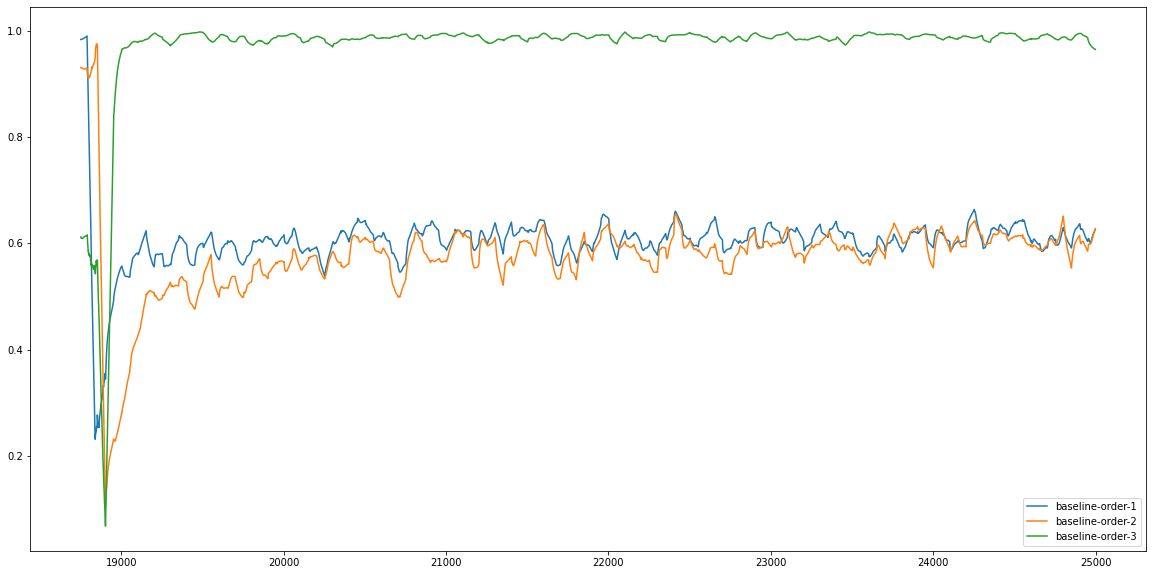

In [18]:
t=3
online_df = pd.concat(dfs, axis=1).drop("accuracy", axis=1)
online_df.loc[:, display_names].rolling(window=50, center=True).mean().iloc[6250*t:6250*(t+1), :3].plot()

In [131]:
x = m["online"]

In [132]:
pd.DataFrame(x)

,accuracy,examples_seen,task
0,0.1250,0,yelp
1,0.1250,16,yelp
2,0.1250,32,yelp
3,0.3125,48,yelp
4,0.2500,64,yelp
...,...,...,...
31414,0.8125,502672,yahoo
31415,0.7500,502688,yahoo
31416,0.6875,502704,yahoo
31417,0.8125,502720,yahoo


In [242]:
o

(1, 2, 3, 4)

/home/omarelb/projects/thesis/code/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

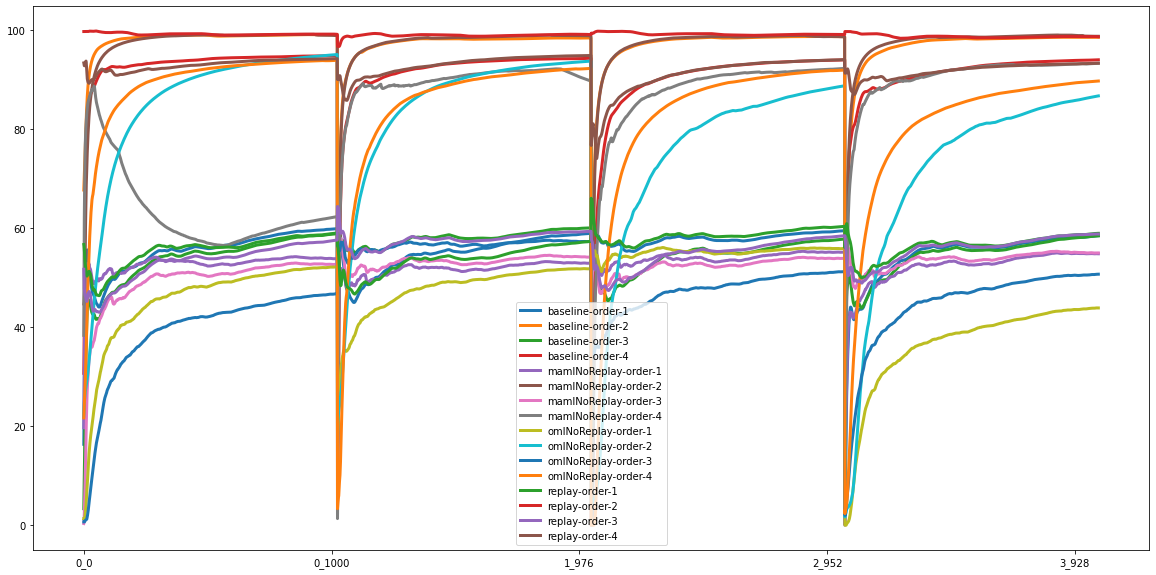

In [237]:
base_col = split + "few_shot_learning_curve_area_"
plot_cols = get_cols(merged, base_col)
first_encounter_cols = get_cols(merged, "first_encounter_learning_curve_area_")
p_cols = plot_cols
p_cols = first_encounter_cols + plot_cols
plot_df = merged.loc[p_cols, :]
plot_df.index = ["_".join(xx.split("_")[-2:]) for xx in merged.loc[p_cols, :].index]
# ax = merged.loc[plot_cols, :].plot(lw=1)
# ax.legend(fontsize=12)
plot_df.plot(lw=3)
# ax.set_xticks([])

## Learning curve area difference all evaluations

/home/omarelb/projects/thesis/code/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


[]

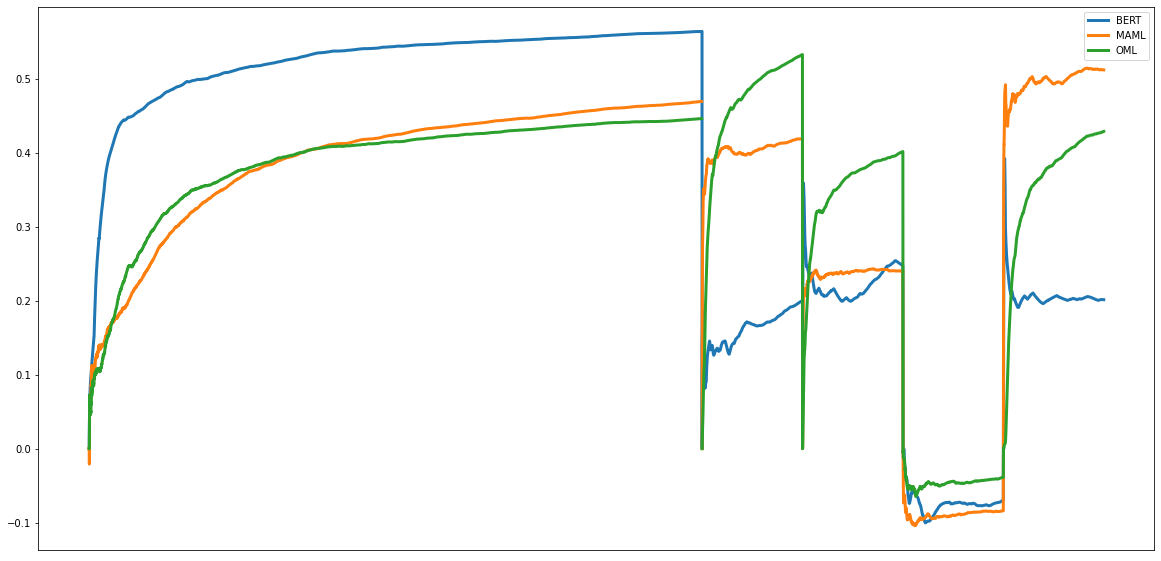

In [134]:
base_col = split + "few_shot_learning_curve_area_difference"
plot_cols = get_cols(merged, base_col)
first_encounter_cols = get_cols(merged, "first_encounter_learning_curve_area_difference")
p_cols = plot_cols
p_cols = first_encounter_cols + plot_cols
ax = merged.loc[p_cols, :].plot(lw=3)
# ax.axhline(0)
ax.set_xticks([])

In [135]:
merged.loc[[split + x for x in ["forgetting_0", "forgetting_1", "forgetting_2", "forgetting_3"]], :]

,BERT,MAML,OML
test_forgetting_0,0.625,0.87,0.98
test_forgetting_1,0.875,0.70,0.83
test_forgetting_2,0.295,0.37,0.41
test_forgetting_3,0.875,0.97,1.00


## Learning speed all evaluations

/home/omarelb/projects/thesis/code/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


[]

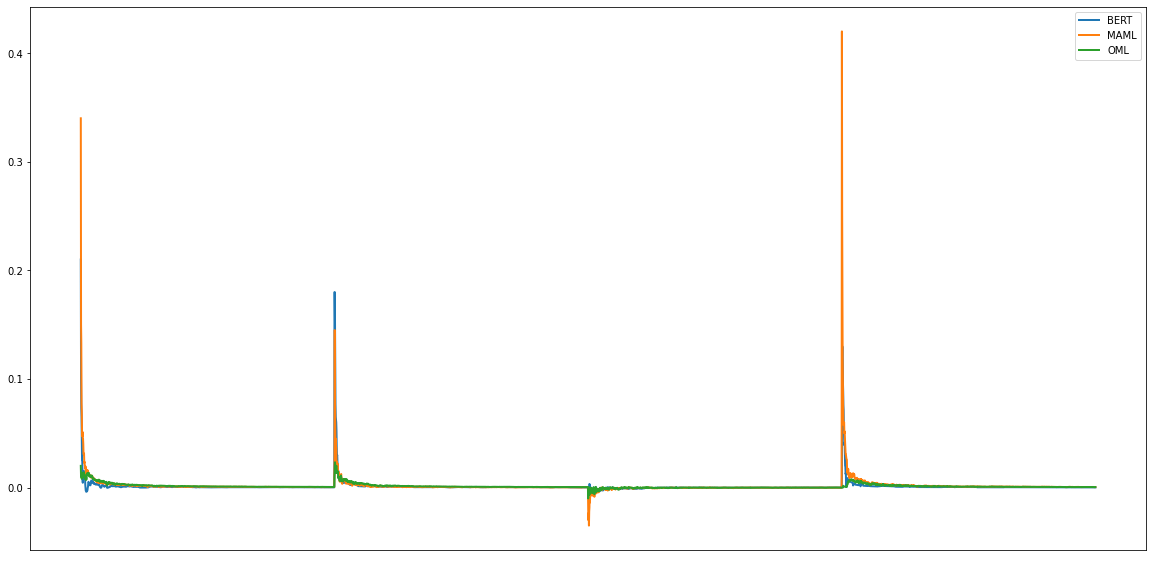

In [136]:
base_col = split + "few_shot_learning_speed_"
plot_cols = get_cols(merged, base_col)
first_encounter_cols = get_cols(merged, "first_encounter_learning_curve_area_difference")
ax = merged.loc[plot_cols, :].plot(lw=2)
ax.set_xticks([])

## *Re*learning curve area difference all evaluations

/home/omarelb/projects/thesis/code/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


[]

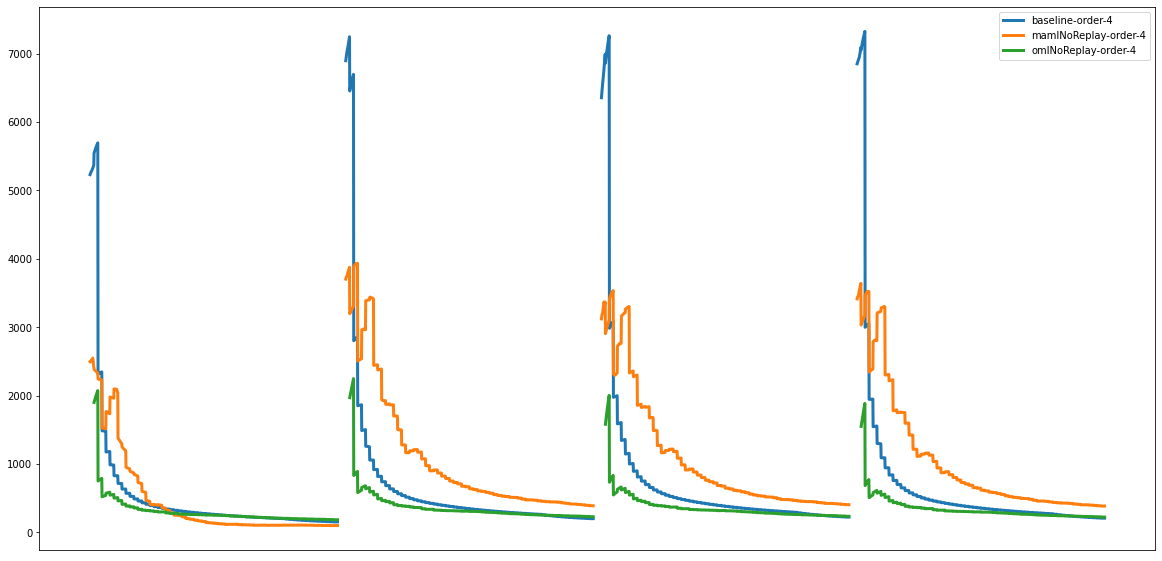

In [252]:
og = [g for _, g in order_grouped]
plot_df = og[3]
base_col = split + "few_shot_relearning_curve_area_difference_"
plot_cols = [col for col in merged.index if re.match(base_col + "\d", col) is not None]
ax = plot_df.loc[plot_cols, :].iloc[:, :-1].plot(lw=3)
ax.set_xticks([])

## *Re*learning speed all evaluations

/home/omarelb/projects/thesis/code/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


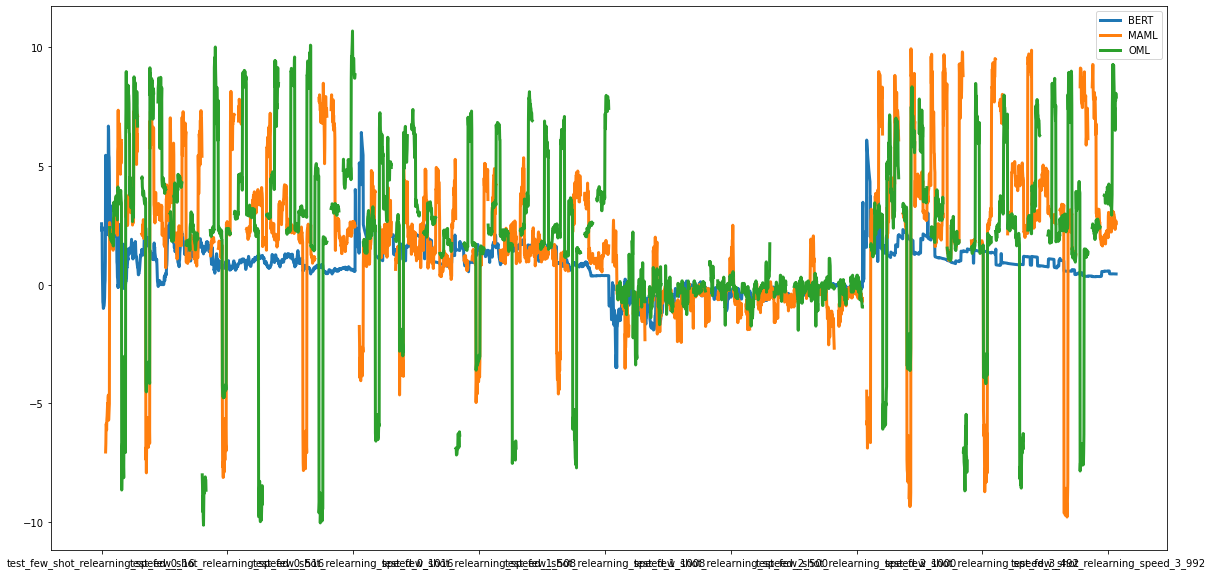

In [138]:
base_col = split + "few_shot_relearning_speed_"
plot_cols = [col for col in merged.index if re.match(base_col + "\d", col) is not None]
ax = merged.loc[plot_cols, :].plot(lw=3)
# ax.set_xticks([])

## Learning curve area 1 evaluation

/home/omarelb/projects/thesis/code/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

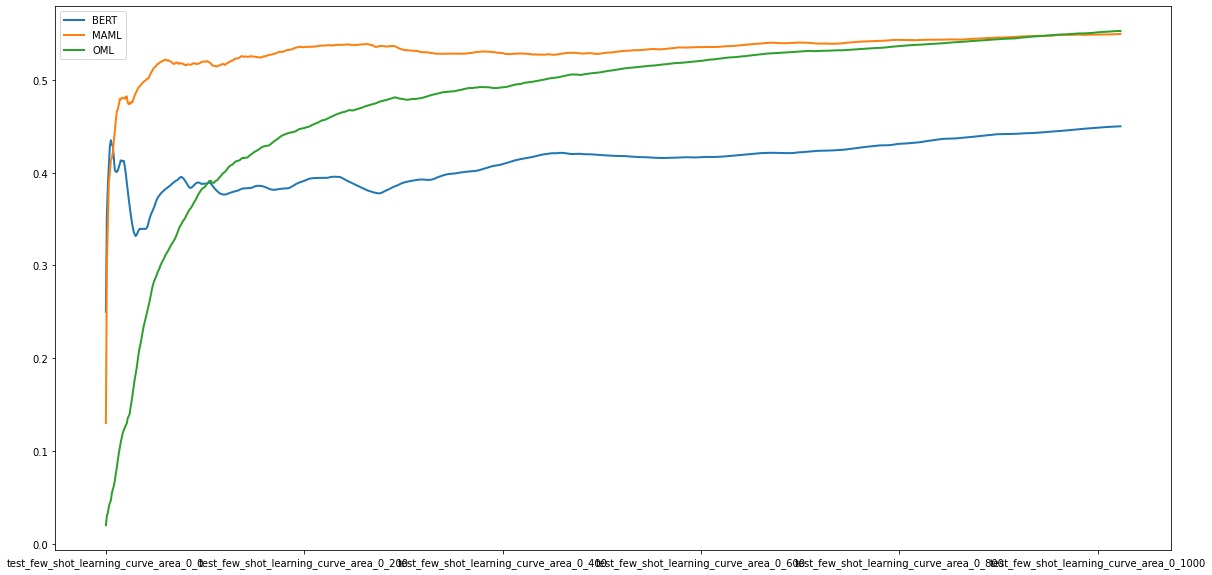

In [139]:
nth_eval = 0
base_col = split + f"few_shot_learning_curve_area_{nth_eval}_"
plot_cols = [col for col in merged.index if re.match(base_col + "\d", col) is not None]
merged.loc[plot_cols, :].plot(lw=2)

## Learning curve area difference 1 evaluation

/home/omarelb/projects/thesis/code/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


[]

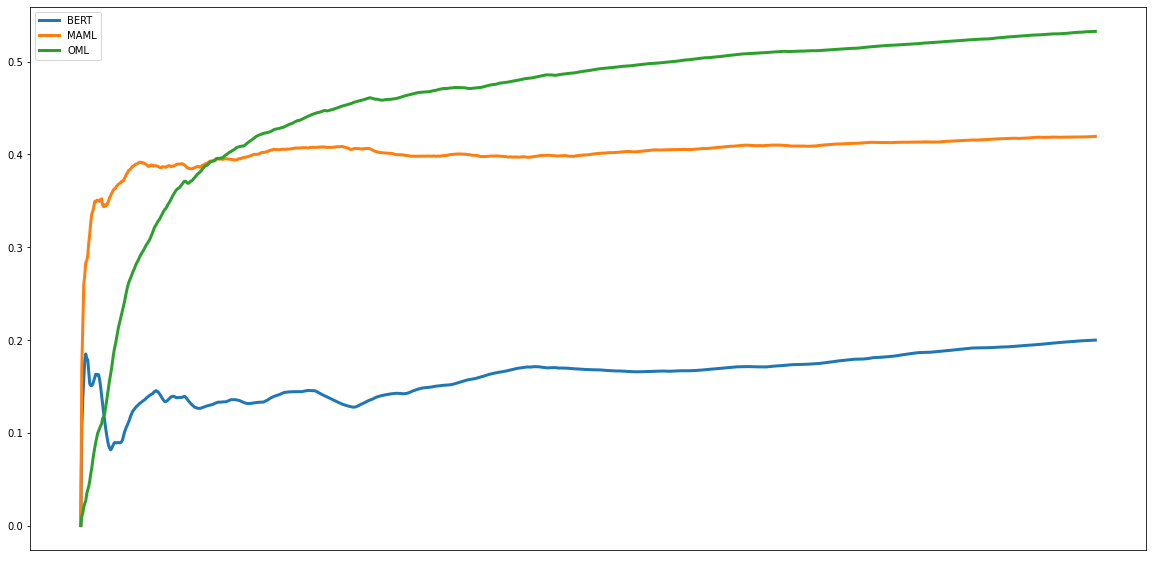

In [140]:
base_col = split + f"few_shot_learning_curve_area_difference_{nth_eval}_"
plot_cols = [col for col in merged.index if re.match(base_col + "\d", col) is not None]
ax = merged.loc[plot_cols, :].plot(lw=3)
ax.set_xticks([])

## Learning speed 1 evaluation

/home/omarelb/projects/thesis/code/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

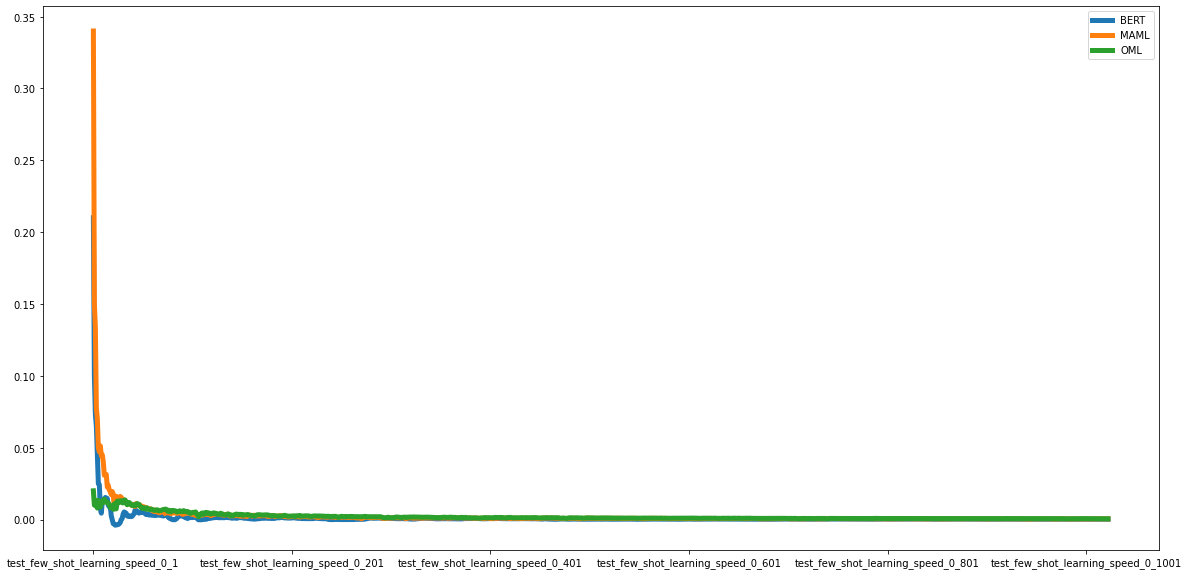

In [141]:
base_col = split + f"few_shot_learning_speed_{nth_eval}_"
plot_cols = [col for col in merged.index if re.match(base_col + "\d", col) is not None]
merged.loc[plot_cols, :].plot(lw=5)

## Relearning curve area difference 1 evaluation

/home/omarelb/projects/thesis/code/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


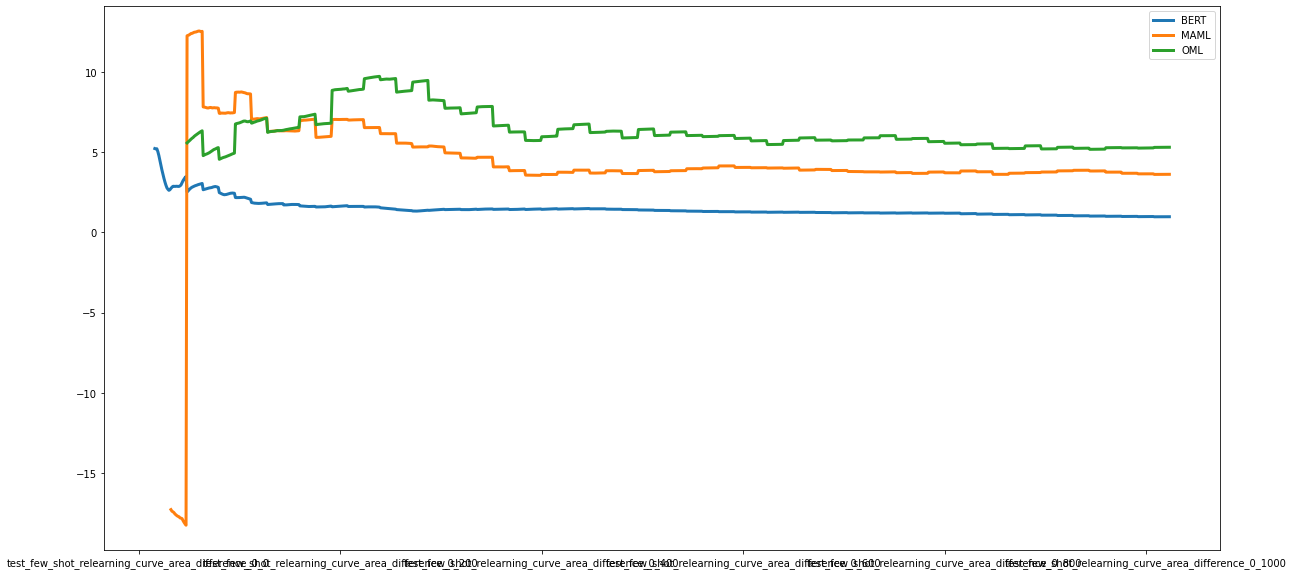

In [142]:
base_col = split + f"few_shot_relearning_curve_area_difference_{nth_eval}_"
plot_cols = [col for col in merged.index if re.match(base_col + "\d", col) is not None]
ax = merged.loc[plot_cols, :].plot(lw=3)
# ax.set_xticks([])

In [143]:
# for exp in list(EXPERIMENT_DIR.glob("measure-relearning*")):
#     if "measure-relearning-multiple-eval-order" in exp.name: 
#         try:
#             print(exp)
#             analyze_results(exp / "seed=42" / "results" / "metrics.json", make_plots=False)
#         except Exception as e:
#             print(e)
#             pass

## Few shot relearning curve area

In [45]:
experiments

[PosixPath('/home/omarelb/projects/thesis/code/experiments/measure-relearning-multiple-eval-baseline-all-order-4-100000'),
 PosixPath('/home/omarelb/projects/thesis/code/experiments/measure-relearning-multiple-eval-mamlNoReplay-all-order-4-100000'),
 PosixPath('/home/omarelb/projects/thesis/code/experiments/measure-relearning-multiple-eval-omlNoReplay-all-order-4-100000'),
 PosixPath('/home/omarelb/projects/thesis/code/experiments/measure-relearning-multiple-eval-replay-all-order-4-100000')]

In [47]:
with open(experiments[-1] / "seed=44" / "results" / "metrics.json") as f:
    m = json.load(f)

In [ ]:
for experiment in experiments:
     analyze_results(experiment / "seed=44" / "results" / "metrics.json", make_plots=False)

In [ ]:
few_shot_metrics = m["test_evaluation"]["few_shot"][3]

In [ ]:
get_forgetting(few_shot_metrics, m)

In [ ]:
m["test_evaluation"]["few_shot"][3]

In [ ]:
x = [ex["examples_seen"] for ex in m["evaluation"]["few_shot"][2]]
y = [ex["accuracy"] for ex in m["evaluation"]["few_shot"][2]]
plt.plot(x, y)

In [ ]:
few_shot = ["test_few_shot_learning_curve_area_difference_\d_4"]

In [24]:
np.unique(["_".join(col.split('_')[:-1]) for col in merged.index])

array(['first_encounter_best', 'first_encounter_initial',
       'first_encounter_learning_curve_area',
       'first_encounter_learning_curve_area_difference',
       'first_encounter_learning_curve_area_difference_expanded',
       'first_encounter_learning_curve_area_expanded',
       'first_encounter_learning_speed',
       'first_encounter_learning_speed_expanded', 'forgetting', 'online',
       'test_average', 'test_few_shot_learning_curve_area_0',
       'test_few_shot_learning_curve_area_1',
       'test_few_shot_learning_curve_area_2',
       'test_few_shot_learning_curve_area_3',
       'test_few_shot_learning_curve_area_difference_0',
       'test_few_shot_learning_curve_area_difference_1',
       'test_few_shot_learning_curve_area_difference_2',
       'test_few_shot_learning_curve_area_difference_3',
       'test_few_shot_learning_speed_0', 'test_few_shot_learning_speed_1',
       'test_few_shot_learning_speed_2', 'test_few_shot_learning_speed_3',
       'test_few_shot_rel

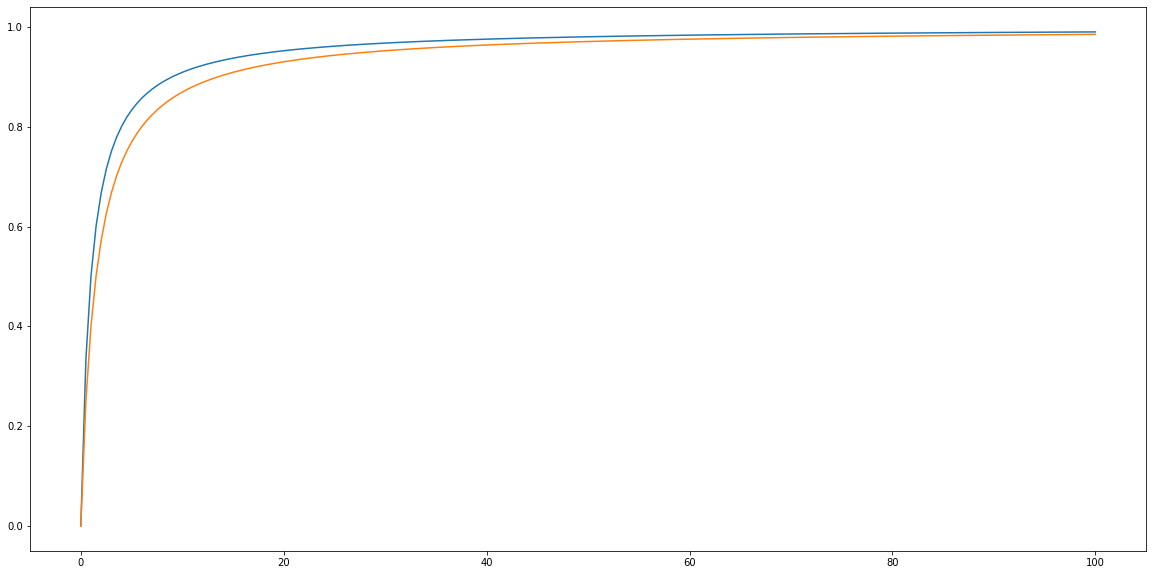

In [168]:
x = np.linspace(0, 100, num=200)
y1 = x / (x + 1)
y2 = x / (x + 1.5)
plt.plot(x, y1, x, y2)